# Lineage tracing

_TL;DR we provide a brief overview assays providing measurments of both cell state and lineage history and on the available computational pipelines using a leading example, tracing tumor development in a mouse model of lung cancer._

## Motivation

Cellular lineages are ubiquitious in biology. Perhaps the most famous example is that of embyrogenesis: the process by which an organism like a human being is generated from from a single cell, the fertilized egg. During this process, subsequent cell divisions give rise to daughter cells and over time entire "lineages" that take on specialized roles within the developing embryo. The amazing complexity of this process has captured the imagination of scientists for centuries, and over the past century and a half our understanding of this process has been bolstered by the development of high-throughput sequencing assays and new "lineage tracing" technologies for visualizing and characterizing this process {cite}`woodworth2017`. Amongst the most exciting of these methods allow investigators to link measurements of cell state with models of their history, thus providing a window into how differentiation trajectories might have unfolded.

The marriage of single-cell assays and lineage tracing approaches has yielded an exponential growth in the complexity of datasets, requiring the development of new computational methodology for their analysis. As such, there has been a strong need in developing new computational methodology for processing these datasets {cite}`gong2021`. Sourcing heavily from population genetics literature, the past half decade has witnessed an exciting confluence of traditional concepts in evolutionary biology with cutting-edge genome engineering techniques.     

In this chapter, we provide a brief overview of these new technologies and focus on the available computational pipelines for the analysis of their output and extraction of biological insight. To note, we pay special focus with our example to the CRISPR/Cas9-based "evolving" lineage tracing setting. For a more complete view of other useful experimental alternatives, we refer the interested reader to the excellent reviews by McKenna & Gagnon {cite}`mckenna2019`, Wagner & Klein {cite}`wagner2020`, and VanHorn & Morris {cite}`vanhorn2021`.

## Lineage tracing technologies

The goal of lineage tracing techniques is to infer lineage, or ancestry relationships between observed cells. In this, there are two major variables to consider: scale and resolution. Classical approaches relied heavily on visual observation: for example, in the 1970s Sulston and colleagues derived the first developmental lineage of the nematode _C. elegans_ by meticulously watching cell divisions under a microscope {cite}`sulston1983`. While playing an imperative role in the progression of the field, such approaches cannot scale to complex organisms with more stochastic developmental lineages.

Over the past two decades, the development of revolutionary sequencing assays and microfluidic devices has contributed to the development of new and diverse lineage tracing methodology {cite}`wagner2020`. To digest the plethora of techniques, it is helpful to classify approaches as "_prospective_" or "_retrospective_":

- __Prospective lineage tracing__ approaches enable investigators to trace the descendants of a single cell (i.e., a "_clone"_ or "_clonal population_"). Typically, this is done by introducing a heritable marker into a cell (termed a "_clonal progenitor_") that is passed on from generation to generation.
- __Retrospective lineage tracing__ approaches use variability observed in cells - such as naturally occurring genetic mutations - to infer a model of their lineage (or "_phylogeny_") summarizing the cell division history in a clonal population.  

Several approaches have been developed for prospectively tracing a clonal population: for example, recombinases under a tissue-specific promoter can be used to activate fluorescent markers that act as heritable marks for a specific tissue lineage {cite}`weissman2015brainbow`, {cite}`nagy2000`, {cite}`liu2020genetic`, {cite}`liu2020triple`, {cite}`he2017`. Alternatively, lentiviral transduction can be used to integrate random DNA barcodes into cellular genomes to provide a heritable mark that can be used to deconvolve clonal identities with a sequencing readout {cite}`gerrits2010`, {cite}`biddy2018`, {cite}`weinreb2020`, {cite}`yao2017`. Though these approaches are highly scalable and often do not require heavy genome engineering, they can only report properties at the clonal-level such as clone size and composition.

Retrospective lineage tracers overcome these limitations and provide an additional advantage over prospective tracers by reporting properties about the *sub*clonal dynamics of clones. Traditionally, this has been done by leveraging natural variation between cells to reconstruct a cell division history, such as single-nucleotide variation {cite}`vogelstein2013`, {cite}`turajlic2016`, {cite}`bailey2021`, {cite}`gerstung2020`, {cite}`abyzov2020`, {cite}`bizzotto2021`, {cite}`seokju2017` or copy-number-variation {cite}`patel2014`, {cite}`gao2021`. While this approach is still widely and successfully used to study human tumors or tissue developmental histories, experimentalists have little or no control over how often or where mutations occur. In experimental models, there are opportunities to recapitulate the advantages of retrospective tracers while improving on the caveats by engineering evolvable lineage tracers. Such evolving tracers typically consist of engineering cells with a "scratchpad" (or, synonymously, "target site") that can acquire mutations {cite}`wagner2020`, {cite}`mckenna2019`. For example, a popular approach that this chapter focuses on uses Cas9 to introduce insertions and deletions (i.e., "indels") at the target site {cite}`mckenna2016whole`, {cite}`spanjaard2018`, {cite}`chan2019`, {cite}`frieda2017`, {cite}`kalhor2018`, {cite}`alemany2018`. In this way, cellular lineages acquire heritable mutations over time that can be subsequently read out with high-throughput sequencing platforms and used to infer phylogenies representing a model of the cell lineage. Building on this work, additional technologies have emerged that improve the interpretability of this data: for example, approaches like peCHYRON {cite}`loveless2021` and DNA Typewriter {cite}`choi2022` introduce ordered, sequential edits to allow for more confident assessment of lineage histories.  

Both classes of lineage-tracing approaches can take advantage of adjacent advances in single-cell multiomic profiling. For example, investigators have routinely used single-cell RNA-seq (scRNA-seq) to read out simultaneously the functional state of single cells and their lineage relationships {cite}`raj2018large`, {cite}`chan2019`, {cite}`weinreb2020`, {cite}`wagner2020`, {cite}`spanjaard2018`. This multimodal readout has created opportunities for new computational methodologies, which we detail below. 

As stated above, in this chapter we provide a **detailed walkthrough on the analysis of data from evolving CRISPR/Cas9-based lineage tracers.**

<div class="alert alert-block alert-warning" style="color:black;">
<b>Important Definitions</b> 
<br/br>
    We've used a few terms above that can be confusing to first-time readers. Briefly, we offer some definitions before moving on:
<ul>
    <li> <b>clonal population (or, clone)</b>: The full set of descendants of a specific cell progenitor.</li>
    <li> <b>clonal progenitor</b>: The original single-cell giving rise to a clonal population.</li>
    <li> <b>subclonal resolution</b>: Insights into the relationships between subsets of cells within a clonal population. </li>
    <li> <b>phylogeny</b>: A model of the cell division history of a clonal population, represented as a tree.</li>
    <li> <b>scratchpad (or, target site)</b>: A synthetic, exogeneous region capable of accumulating targeted variation in evolving lineage tracing technologies.</li>
</ul>
</div>

## Overview of evolving lineage tracing data analysis pipelines

Before delving into the analysis of our example dataset, we will provide an overview of the computational pipeline for the analysis of data generated by evolving tracers (based on {cite}`jones2020`). In general, with these systems, analysis will begin with raw sequencing data of an _amplicon_ library of target sites (often derived from a conventional scRNA-seq platform like 10X Chromium). Depending on the technology at hand, each sequenced amplicon will be between 150-300bp long; in the case of CRISPR/Cas9-based evolving tracers, each read will contain one more Cas9 cut sites. Within the preprocessing of this data, analysts are tasked with aligning the reads to a reference sequence and identifying any mutations (e.g., indels). 

While the preprocessing of these datasets is a critical step, in the interest of space, we focus on analysis pipelines that receive preprocessed sequencing data as input and refer the reader to an external preprocessing tutorial which can be found [here](https://cassiopeia-lineage.readthedocs.io/en/latest/notebooks/preprocess.html). 

![SegmentLocal](../_static/images/trajectories/CRISPR-Cas9-based.gif "CRISPR/Cas9")

In most analysis frameworks, the preprocessing of the raw sequencing reads produces a data structure called the **character matrix** that summarizes the observed mutations in each cell across the target sites. In this data structure, each row is a cell (or "sample"), each column is a target site (or "character"), and the (row, column) values are categorical variables representing the identity of the indel observed in that cell at that particular cut site (or "character-state"). Depending on the technology at hand, these character matrices can report on anywhere between 100 and 10,000 samples across up to 100 characters.

At this point, this data structure abstracts away the technicalities of the evolving lineage tracing assay and opens up the opportunity to computationally infer a **phylogenetic tree** over the cells. Specifically, the goal is to learn a hierarchical tree structure over each of the cells in our character matrix. In this tree, each node represents a sample and each edge represents a lineage relationship. Importantly, we often have only observed the _leaves_ of the tree and we refer to any of the unobserved set of internal nodes as _ancestral_ nodes. (To note, we tend to use the term "phylogenetic tree" loosely as this has a precise definition. In reality, we often infer a cladogram summarizing the relationships between cells.)

There are many algorithmic choices for inferring the phylogenetic tree from the character matrix, which can be generally broken up into "character-based" and "distance-based" approaches:
- **Character-based**: perform a combinatorial search through all possible tree topologies while seeking to optimize a function over the characters (e.g., the likelihood of the evolutionary history given the mutations observed in the characters).
    - Maximum Parsimony {cite}`cavalli1963`: Find a tree with the minimum number of mutations.
    - Maximum Likelihood {cite}`felsenstein1981`: Find a tree with the most likely mutation history (for a lineage tracing-specific algorithm, we refer the reader to GAPML{cite}`gapml`).
    - Bayesian Phylogenetic Inference {cite}`huelsenbeck2001`: Find a tree that maximizes the posterior probability of the evolutionary history given observed mutations.
    
- **Distance-based**: use a notion of cell-cell distances (such as the number of edits that they share, denoted by $\delta$) to infer a phylogenetic tree and typically run in polynomial time. While distance-based approaches can perform much faster, they require one to iteratively find the best cell-cell dissimilarity function which can be equally time consuming.
    - Neighbor-Joining {cite}`neighbor-joining`: Produces a tree from a given cell-cell dissimilarity matrix by iteratively finding pairs that minimize a branch length according to specific criteria.
    - UPGMA {cite}`upgma`: Produces a tree from a given cell-cell dissimilarity matrix using a faster algorithm than Neighbor-Joining. However, it has more strict requirements to produce an accurate tree.

Traditionally, the task of inferring phylogenies from this type of data is challenging and often requires the application of combinatorial algorithms with poor scalability. In applying such algorithms to the single-cell evolving lineage-tracers previously described, these problems become exacerbated as the number of cells sampled is routinely an order or magnitude larger than the number of species assessed in traditional phylogenetic studies. These challenges are further compounded with non-random missing data and non-uniform editing distributions. Fortunately, there have been recent algorithmic developments for addressing the modeling challenges for evolving lineage tracers {cite}`jones2020`, {cite}`gapml`, {cite}`gong2021` and for scaling inference to extremely large trees with deep distributed computing {cite}`konno2022`. In practice, the majority of applications have used variants of maximum-parsimony approaches or distance-based approaches like Neighbor-Joining for their tree inference. However, this is currently an active area of development and for a more in-depth discussion, we refer the reader to the Conclusions.

Following phylogenetic tree reconstruction, there are several options for _downstream analysis_. For example, one can learn about the rates of cell state changes across the developmental history or the relative propensities of cells to divide in a population. Below, we will demonstrate via code examples how these different components fit together to gain fundamental insights into the dynamic processes underlying cellular lineages.


## `Cassiopeia` for lineage tracing analysis

In this tutorial, we will primarily make use of `Cassiopeia`, one of the few packages for lineage tracing analysis {cite}`jones2020`.

Generally, `Cassiopeia` is a software suite for processing and analyzing evolving lineage tracing sequencing data. The software contains four major modules:
1. preprocessing sequencing reads from evolving lineage tracing datasets (e.g., CRISPR/Cas9-based lineage tracers) into character matrices.
2. reconstructing phylogenies from these character matrices with one of several algorithms available in the codebase
3. providing analysis tools for deriving insights from reconstructed phylogenies.
4. simulating realistic phylogenies and lineage tracing data for benchmarking purposes

Though these modules fit together in the `Cassiopeia` pipeline, they are additionally independent of one another. For example, a user might use a different software suite for lineage inference but use tools in the `Cassiopeia` codebase for post-reconstruction analysis.

For more installation guidelines and additional documentation, we refer the reader [here](https://cassiopeia-lineage.readthedocs.io/en/latest/index.html).


## Tracing tumor development in a mouse model of lung cancer
In this case study, we will make use of the recent study presented in {cite}`yang2022`. Briefly, in this study the authors integrated a evolving CRISPR/Cas9-based lineage tracer into the KP mouse model of non-small-cell lung cancer {cite}`dupage2009`. Specifically, this mouse model carries oncogenic _Kras_ and _Tp53_ mutations that under native conditions are not expressed. However, upon the introduction of Cre recombinase via lentiviral inhalation, these oncogenic mutations are activated in single cells of the lung airway epithelium inducing tumors. In this study, the CRISPR/Cas9-based lineage tracer is under similar control and thus becomes active simultaneously upon tumor induction.


<div>
<img src="../_static/images/trajectories/tumor_tracing.png" width="1000"/>
</div>

With this system, the authors followed tumors from their single-cell origins over the course of approximately 4.5-6 months at which point they harvested aggressive, metastatic tumors. After dissociation of the tumors, the authors profiled both the lineage tracing target sites and the RNA content of single cells. This resulted in a large dataset of more than 70,000 cells across more than 100 tumors with both lineage and scRNA-seq information.

In this tutorial, we will demonstrate how a user can take processed target site data to learn interesting dynamic properties of lineages. Throughout this case study, each lineage will correspond to a single primary tumor sampled from a mouse lung.

<div class="alert alert-block alert-warning" style="color:black;">
<b>Overview of input data:</b> 
<br/br>
    Before moving on, make sure you understand what data types we'll be utilizing. As discussed above, we are equipped with scRNA-seq count matrices and, separately, lineage tracing data (this can come in many forms; below, we begin with the <b>allele table</b> which summarizes the indels observed on each target within a cell. This is described more below). These two data will be processed separately. The lineage tracing data will be used to infer lineages, and the scRNA-seq data will be used to interpret interesting behaviors of these lineages.
</div>

<div class="alert alert-block alert-warning" style="color:black;">
<b>Structure of the lineage tracer:</b> 
<br/br>
    For the dataset analyzed below, each cell is engineered with approximately 10 target sites, each of which carrying 3 Cas9 cut sites in tandem. Each target site is labeled with a unique integration barcode ("intBC" for short). All together, we can expect to observe 3*(# target sites) characters in each cell that can accumulate mutations and be used for lineage inference. For more information on the structure of the sequencing cassette, please refer to <a href="https://www.nature.com/articles/s41586-019-1184-5">Chan, Smith et al. Molecular recording of mammalian embryogenesis. Nature 2019</a>.
</div>


### Downloading the data
This data is publicly hosted on [Zenodo](https://zenodo.org/record/5847462#.YrFDKuzMI6A) and we can download the data as follows:

In [8]:
!wget "https://zenodo.org/record/5847462/files/KPTracer-Data.tar.gz?download=1"

--2022-06-30 10:28:22--  https://zenodo.org/record/5847462/files/KPTracer-Data.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1304975216 (1.2G) [application/octet-stream]
Saving to: ‘KPTracer-Data.tar.gz?download=1’

KPTracer-Data.tar.g 100%[===================>]   1.21G  1.49MB/s    in 7m 3s   

2022-06-30 10:35:27 (2.94 MB/s) - ‘KPTracer-Data.tar.gz?download=1’ saved [1304975216/1304975216]



In [ ]:
!tar -xvzf KPTracer-Data.tar.gz?download=1

### Environment setup.

Before we enter this notebook's analysis, let's set up our environment.

In [1]:
import cassiopeia as cas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

from cassiopeia.preprocess import lineage_utils

### Examine the data

After preprocessing of the target site sequencing data, `Cassiopeia` uses an `allele_table` to summarize the mutations observed on each target site integration.

As described above, the system at hand should have approximately ~10 target sites per cell where each target site contains three Cas9 cut sites. Columns labeled `intBC` indicate the target site and columns labeled `r*` indicate the Cas9 cut sites on that target site. Mutations in each cut site are stored as CIGAR strings, indicating the size and type of indel observed. 

Other metadata can also be stored in this table such as the total number of UMIs and reads associated with the target site molecule, which cell the molecule came from, and which tumor that cell belongs to.

In [2]:
allele_table = pd.read_csv(
    "KPTracer-Data/KPTracer.alleleTable.FINAL.txt", sep="\t", index_col=0
)

allele_table.head(5)

/var/folders/kt/wk3kbll507v4h18f8nmbzkl80000gq/T/ipykernel_65366/3031588044.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  allele_table = pd.read_csv("KPTracer-Data/KPTracer.alleleTable.FINAL.txt", sep='\t', index_col = 0)


,cellBC,intBC,r1,r2,r3,allele,sampleID,UMI,readCount,Tumor,MetFamily,ES_clone
0,L9.TTTGTCATCTGTCAAG-1,TTCCCTATTTGCTA,CGCCG[111:2D]AAATG,GATAT[None]CTCTG,AATTC[220:1I]GGCGGA,CGCCG[111:2D]AAATGGATAT[None]CTCTGAATTC[220:1I...,L9,54,796,3724_NT_T1,3724_NT_T1,2E1
1,L9.TTTGTCATCTGTCAAG-1,TGTTTTTGTCTGCA,CGCCG[111:1I]AAAAAA,CATGT[151:19D]TGGTT,TTAAT[218:2D]GCGGA,CGCCG[111:1I]AAAAAACATGT[151:19D]TGGTTTTAAT[21...,L9,13,209,3724_NT_T1,3724_NT_T1,2E1
2,L9.TTTGTCATCTGTCAAG-1,TGTGAAGGTCAATA,CCGAA[113:49D]GATAT,CCGAA[113:49D]GATAT,AATTC[220:5D]GGACA,CCGAA[113:49D]GATATCCGAA[113:49D]GATATAATTC[22...,L9,68,1193,3724_NT_T1,3724_NT_T1,2E1
3,L9.TTTGTCATCTGTCAAG-1,TCAGGCGATGCGAA,CGCCG[111:1I]AAAAAA,CGATA[166:1I]TTCTCT,TAATT[219:2D]CGGAG,CGCCG[111:1I]AAAAAACGATA[166:1I]TTCTCTTAATT[21...,L9,43,745,3724_NT_T1,3724_NT_T1,2E1
4,L9.TTTGTCATCTGTCAAG-1,TATGATTAGTCGCG,CGCCG[111:1D]AAAAT,GATAT[167:54D]CGGAG,GATAT[167:54D]CGGAG,CGCCG[111:1D]AAAATGATAT[167:54D]CGGAGGATAT[167...,L9,27,530,3724_NT_T1,3724_NT_T1,2E1


We'll focus on the data from KP tumors without any additional perturbations:

In [3]:
all_tumors = allele_table["Tumor"].unique()
primary_nt_tumors = [
    tumor
    for tumor in all_tumors
    if "NT" in tumor and tumor.split("_")[2].startswith("T")
]

primary_nt_allele_table = allele_table[allele_table["Tumor"].isin(primary_nt_tumors)]

As described above, we expect to see around 10 unique intBCs (i.e., target sites) per tumor population. Below, we summarize some key statistics for the dataset.

#### Number of intBCs per Tumor

One statistic of interest to analysts is the **number of intBCs per tumor** as this informs on the information capacity for each clonal population.

In recent applications ({cite}`yang2022`), we find that high-quality clones typically have between 5 and 30 intBCs (corresponding to 15-90 characters). In plotting the number of intBCs per tumor, we can make sure there are not outliers tumors that we'd like to filter out before reconstruction.

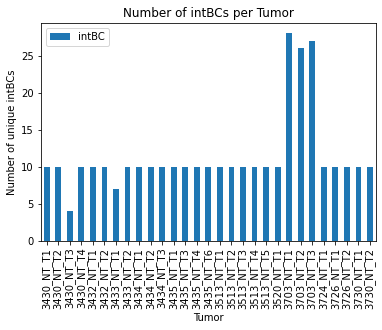

In [4]:
primary_nt_allele_table.groupby(["Tumor"]).agg({"intBC": "nunique"}).plot(kind="bar")
plt.ylabel("Number of unique intBCs")
plt.title("Number of intBCs per Tumor")
plt.show()

As expected, we observe that the majority of tumors have around 10 intBCs while one tumor reports few observed intBCs and a few report more than 25 intBCs.  Next we will discuss strategies for filtering out low-quality tumors.

#### Size of each tumor

We are also interested in the size of the tumors that will be reconstructed. It's typical to observe clones between 100 and 10,000 cells. Once again, we'll want to make sure there are no clear outliers - specifically, clones that are too small for reconstruction (usually fewer than 100 cells). 

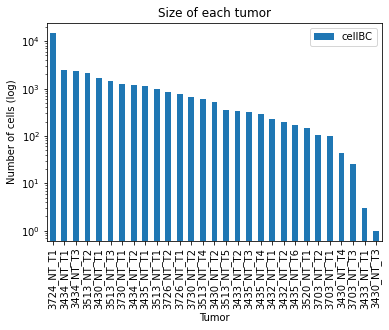

In [5]:
primary_nt_allele_table.groupby(["Tumor"]).agg({"cellBC": "nunique"}).sort_values(
    by="cellBC", ascending=False
).plot(kind="bar")
plt.yscale("log")
plt.ylabel("Number of cells (log)")
plt.title("Size of each tumor")
plt.show()

We see that we have one very large clone (with ~30,000 cells) and the rest of the clones are in the expected range, reporting between 1,000 and 5,000 cells.  

### Preparing the data for lineage reconstruction

A general feature of Cas9-based tracers is that certain insertions and deletions are much more common than others. This can be an important modeling concern as high-probability edits can occur several times independently of one another and could potentially lead to an analyst incorrectly believing that two cells are related to one another. 

Cassiopeia has a built-in utility for estimating the prior probabilities of insertions and deletions by counting the number of times that an indel appeared in unrelated tumors or intBCs. 

In observing the frequencies of observed indels, we see that a few indels (small deletions or insertions) appear quite often in clones. On the other hand, we also observe several edits observed in a single clone. Because of the difference in frequencies, an analyst should try to incorporate these observed biases into downstream analyses.

In [6]:
indel_priors = cas.pp.compute_empirical_indel_priors(
    allele_table, grouping_variables=["intBC", "MetFamily"]
)

indel_priors.sort_values(by="count", ascending=False).head()

,count,freq
indel,,
TAATT[219:2D]CGGAG,664.0,0.764977
CGCCG[111:1I]AAAAAA,584.0,0.672811
CGCCG[111:1D]AAAAT,504.0,0.580645
CGCCG[111:2D]AAATG,401.0,0.461982
AATTC[220:3D]GAGGA,395.0,0.455069


In [7]:
indel_priors.sort_values(by="count").head(5)

,count,freq
indel,,
ATATC[168:49I]GTTGTGGCCCAACATGGCAGCGTGCCGTAGCTTAGTTGTCAGGCCATTTGCTGG,1.0,0.001152
ACGCC[110:2D]AGAAT,1.0,0.001152
CATCT[101:15D]TGGCC,1.0,0.001152
CCCGG[111:3D]ATTGG,1.0,0.001152
CCGAA[113:1I]GGAATG,1.0,0.001152


#### Filtering out low-quality tumors
Before tumor reconstruction, we'll filter out tumors with (i) poor lineage tracing kinetics or (ii) that are too small to consider for analysis. 

In previous publications ({cite}`quinn2021` and {cite}`yang2022`), we have found that looking at the following statistics are useful for determining the quality of the tumor:
- **percent unique**: This is the percentage of lineage states that are unique in a tumor.
- **percent cut**: This is the percentage of Cas9 targets that are mutated in a population of cells.
- **percent exhausted**: This is the fraction of target sites that are identical across cells (i.e., are exhausted)
- **size of tumor**: The number of cells in a tumor.

In [8]:
# utility functions for computing summary statistics


def compute_percent_indels(character_matrix):
    """Computes the percentage of sites carrying indels in a character matrix.

    Args:
        character_matrix: A pandas Dataframe summarizing the mutation status of each cell.

    Returns:
        A percentage of sites in cells that contain an edit.
    """
    all_vals = character_matrix.values.ravel()
    num_not_missing = len([n for n in all_vals if n != -1])
    num_uncut = len([n for n in all_vals if n == 0])

    return 1.0 - (num_uncut / num_not_missing)


def compute_percent_uncut(cell):
    """Computes the percentage of sites uncut in a cell.

    Args:
        A vector containing the edited sites for a particular cell.

    Returns:
        The number of sites uncut in a cell.
    """
    uncut = 0
    for i in cell:
        if i == 0:
            uncut += 1
    return uncut / max(1, len([i for i in cell if i != -1]))


def summarize_tumor_quality(
    allele_table,
    minimum_intbc_thresh=0.2,
    minimum_number_of_cells=2,
    maximum_percent_uncut_in_cell=0.8,
    allele_rep_thresh=0.98,
):
    """Compute QC statistics for each tumor.

    Computes statistics for each clone that will be used for filtering tumors for downstream lineage reconstruction.

    Args:
        allele_table: A Cassipoeia allele table summarizing the indels on each molecule in each cell.
        min_intbc_thresh: The minimum proportion of cells that an intBC must appear in to be considered
            for downstream reconstruction.
        minimum_number_of_cells: Minimum number of cells in a tumor to be processed in this QC pipeline.
        maximum_percent_uncut_in_cell: The maximum percentage of sites allowed to be uncut in a cell. If
            a cell exceeds this threshold, it is filtered out.
        allele_rep_thresh: Maximum allele representation in a single cut site allowed. If a character has
            less diversity than allowed, it is filtered out.

    Returns:
        A pandas Dataframe summarizing the quality-control information for each tumor.
    """

    tumor_statistics = {}
    NUMBER_OF_SITES_PER_INTBC = 3

    # iterate through Tumors and compute summary statistics
    for tumor_name, tumor_allele_table in allele_table.groupby("Tumor"):

        if tumor_allele_table["cellBC"].nunique() < minimum_number_of_cells:
            continue

        tumor_allele_table = allele_table[allele_table["Tumor"] == tumor_name].copy()
        tumor_allele_table["lineageGrp"] = tumor_allele_table["Tumor"].copy()
        lineage_group = lineage_utils.filter_intbcs_final_lineages(
            tumor_allele_table, min_intbc_thresh=minimum_intbc_thresh
        )[0]

        number_of_cutsites = (
            len(lineage_group["intBC"].unique()) * NUMBER_OF_SITES_PER_INTBC
        )

        character_matrix, _, _ = cas.pp.convert_alleletable_to_character_matrix(
            lineage_group, allele_rep_thresh=allele_rep_thresh
        )

        # We'll hit this if we filter out all characters with the specified allele_rep_thresh
        if character_matrix.shape[1] == 0:
            character_matrix, _, _ = cas.pp.convert_alleletable_to_character_matrix(
                lineage_group, allele_rep_thresh=1.0
            )

        number_dropped_intbcs = number_of_cutsites - character_matrix.shape[1]
        percent_uncut = character_matrix.apply(
            lambda x: compute_percent_uncut(x.values), axis=1
        )

        # drop normal cells from lineage (cells without editing)
        character_matrix_filtered = character_matrix[
            percent_uncut < maximum_percent_uncut_in_cell
        ]

        percent_unique = (
            character_matrix_filtered.drop_duplicates().shape[0]
            / character_matrix_filtered.shape[0]
        )
        tumor_statistics[tumor_name] = (
            percent_unique,
            compute_percent_indels(character_matrix_filtered),
            number_dropped_intbcs,
            1.0 - (number_dropped_intbcs / number_of_cutsites),
            character_matrix_filtered.shape[0],
        )

    tumor_clone_statistics = pd.DataFrame.from_dict(
        tumor_statistics,
        orient="index",
        columns=[
            "PercentUnique",
            "CutRate",
            "NumSaturatedTargets",
            "PercentUnsaturatedTargets",
            "NumCells",
        ],
    )

    return tumor_clone_statistics

#### Calculate and visualize tumors' statistics

In [ ]:
tumor_clone_statistics = summarize_tumor_quality(primary_nt_allele_table)

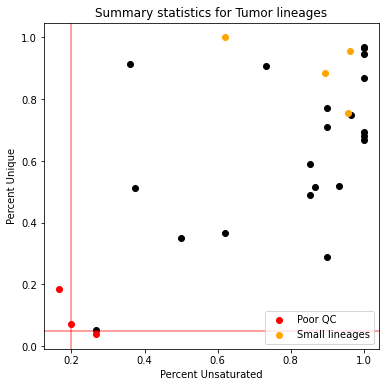

In [66]:
NUM_CELLS_THRESH = 100
PERCENT_UNIQUE_THRESH = 0.05
PERCENT_UNSATURATED_TARGETS_THRESH = 0.2

low_qc = tumor_clone_statistics[
    (tumor_clone_statistics["PercentUnique"] <= PERCENT_UNIQUE_THRESH)
    | (
        tumor_clone_statistics["PercentUnsaturatedTargets"]
        <= PERCENT_UNSATURATED_TARGETS_THRESH
    )
].index
small = tumor_clone_statistics[
    (tumor_clone_statistics["NumCells"] < NUM_CELLS_THRESH)
].index

unfiltered = np.setdiff1d(tumor_clone_statistics.index, np.union1d(low_qc, small))

h = plt.figure(figsize=(6, 6))
plt.scatter(
    tumor_clone_statistics.loc[unfiltered, "PercentUnsaturatedTargets"],
    tumor_clone_statistics.loc[unfiltered, "PercentUnique"],
    color="black",
)
plt.scatter(
    tumor_clone_statistics.loc[low_qc, "PercentUnsaturatedTargets"],
    tumor_clone_statistics.loc[low_qc, "PercentUnique"],
    color="red",
    label="Poor QC",
)
plt.scatter(
    tumor_clone_statistics.loc[small, "PercentUnsaturatedTargets"],
    tumor_clone_statistics.loc[small, "PercentUnique"],
    color="orange",
    label="Small lineages",
)


plt.axhline(y=PERCENT_UNIQUE_THRESH, color="red", alpha=0.5)
plt.axvline(x=PERCENT_UNSATURATED_TARGETS_THRESH, color="red", alpha=0.5)
plt.xlabel("Percent Unsaturated")
plt.ylabel("Percent Unique")
plt.title("Summary statistics for Tumor lineages")
plt.legend(loc="lower right")
plt.show()

This plot summarizes our quality-control filtering efforts. Each point corresponds to a tumor and its color indicates its filter status:

- Tumors colored in <b><font color='red'>red</font></b> are filtered because either they have too few unique states or too few characters that can be used for reconstruction
- Tumors colored in <b><font color='orange'>orange</font></b> are filtered out because they are too small for reconstruction (we use a 100 cell filter) 
- Tumors in **black** have passed our quality-control filters and will be considered for reconstruction.

The tumor `3726_NT_T1` appears to be a lineage with satisfactory tracing data quality and we will reconstruct the tumor lineage using Cassiopeia.

####  Reconstruction of a selected tumor (`3726_NT_T1`)

In order to reconstruct lineages, we'll have to convert the allele table for a particular tumor into a "character matrix". As defined above, these data structures summarize the mutations observed in each target site in each cell. By default, uncut sites are indicated as 0 and missing sites are indicated as -1. All other values in the matrix correspond to unique indels.

The tumor `3726_NT_T1` appears to be a lineage with satisfactory tracing data quality and we will reconstruct the tumor lineage using Cassiopeia.

In [18]:
tumor = "3726_NT_T1"

tumor_allele_table = primary_nt_allele_table[primary_nt_allele_table["Tumor"] == tumor]

n_cells = tumor_allele_table["cellBC"].nunique()
n_intbc = tumor_allele_table["intBC"].nunique()

print(
    f"Tumor population {tumor} has {n_cells} cells and {n_intbc} intBCs ({n_intbc * 3} characters)."
)

Tumor population 3726_NT_T1 has 772 cells and 10 intBCs (30) characters.


In [19]:
(
    character_matrix,
    priors,
    state_to_indel,
) = cas.pp.convert_alleletable_to_character_matrix(
    tumor_allele_table, allele_rep_thresh=0.9, mutation_priors=indel_priors
)

character_matrix.head(5)

Dropping the following intBCs due to lack of diversity with threshold 0.9: ['ACTCTGCTCCAGATr2', 'ACTCTGCTCCAGATr3', 'GCCTACTTAAGTCCr1', 'GTTTATTTCCGTATr3', 'TATGATTAGTCGCGr1', 'TATGATTAGTCGCGr2', 'TGATATAAATCTTTr2', 'TTCCCTATTTGCTAr2', 'TGTTTTTGTCTGCAr1', 'ACAGGTGCTCAAATr1', 'ACAGGTGCTCAAATr2', 'ACAGGTGCTCAAATr3']


Processing characters:   0%|          | 0/18 [00:00<?, ?it/s]

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,r11,r12,r13,r14,r15,r16,r17,r18
L6.TTTGTCACACATCCAA-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1
L6.TTTGGTTTCTGAGTGT-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
L6.TTTGGTTCATGTAAGA-1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
L6.TTTGCGCAGCTCCTCT-1,1,2,3,3,3,3,1,3,3,3,1,1,3,3,3,3,3,0
L6.TTTATGCTCGCCGTGA-1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,4,0


### Reconstructing the lineage
There exist several algorithms for inferring phylogenies, many of which can be employed from the general character matrix format that Cassiopeia uses. Because of this, Cassiopeia has implemented several algorithms that can be used for lineage reconstruction, and many others can be implemented using the general `CassiopeiaSolver` API. Among the most popular algorithms are:

- **VanillaGreedy**: A simple and efficient heuristic-based algorithm that can be good for a first-pass at your lineage reconstruction. Based on the landmark Gusfield algorithm {cite}`gusfield1991` and described in {cite}`jones2020`.
- **Neighbor-Joining**: A classic distance-based algorithm, as described in {cite}`neighbor-joining`.
- **UPGMA**: An efficient distance-based algorithm that has special assumptions about how the samples are related to one another. Originally described in {cite}`upgma`. 
- **ILPSolver**: An implementation of a Steiner-Tree optimization inference algorithm, as described in {cite}`jones2020`. This algorithm is slow (and will often not scale beyond around 1.5k cells) but precise.
- **HybridSolver**: A divide-and-conquer hybrid algorithm that uses a Greedy top-down algorithm to divide the data with a precise algorithm to conquer the subproblems (i.e., the ILPSolver). Described in {cite}`jones2020`.

For the tutorial at hand, we will proceed with the VanillaGreedySolver. Additional solvers from the [Cassiopeia codebase](https://cassiopeia-lineage.readthedocs.io/en/latest/api/solver.html) can be plugged in as alternatives.

To set up inference, we'll instantiate a `CassiopeiaTree` which is a Cassiopeia-specific data structure for storing the character matrix and lineage meta data, as well as providing specific utilities for tree manipulation. We'll also instantiate a `VanillaGreedySolver` which will populate the `tree` field in the `CassiopeiaTree` object.

<div class="alert alert-block alert-warning" style="color:black;">
<b>Choosing an algorithm:</b> 
<br/br>
    Having so many algorithms at your disposal, it might seem daunting to choose the "right" one. For this reason, we often suggest that a user perform inference with a few algorithms for comparison. In addition to this, users will want to consider the size of their dataset and prior benchmarking studies as criteria for selecting the algorithms to use. As a rule of thumb, prior experience has found that the <b>HybridSolver</b> is a good balance between scalability and precision, and <b>Neighbor-Joining</b> is a convenient alternative for comparison (Neighbor-Joining also has the advantage of being a different class of algorithm [distance-based versus character-based], so it might highlight different parts of the lineage). For the tutorial purposes here, we will proceed with the GreedySolver as it is extremely efficient and often can serve as a good first-pass of the data before applying more precise (but slower) algorithms.
</div>

In [20]:
tree = cas.data.CassiopeiaTree(character_matrix=character_matrix, priors=priors)

In [21]:
greedy_solver = cas.solver.VanillaGreedySolver()

Running `greedy_solver.solve` will perform tree inference and populate the `tree` field in the `CassiopeiaTree` object.

After inference, we can take advantage of the Cassiopeia visualization library to study the resulting tree structure. We'll observe that there are some mistakes in the inference, but overall large groups of cells seem to be correctly placed. As described above, this can be a nice first-pass of the data before more time-consuming and sophisticated algorithms are deployed.

filling in multiindex table:   0%|          | 0/6432 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]


(<Figure size 504x504 with 1 Axes>, <AxesSubplot:>)

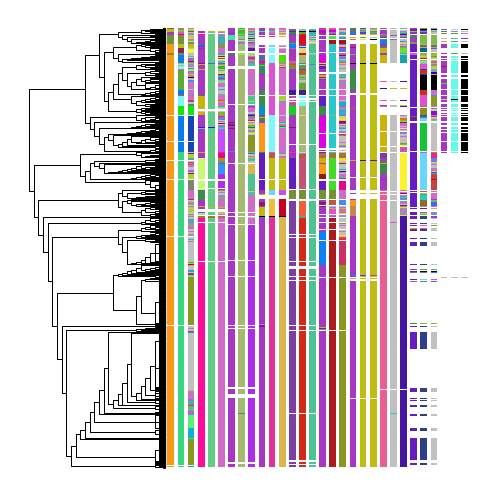

In [22]:
greedy_solver.solve(tree)

cas.pl.plot_matplotlib(tree, orient="right", allele_table=tumor_allele_table)

This representation of the reconstruction can be very useful for assessing algorithmic performance. Assessing the performance of these reconstructions can be quite difficult, but becomes easier with practice. A good tip for starting to assess the performance is to select a column and see if a given indel appears more than once in separate groups of unrelated cells. This might indicate an algorithmic error. 

As one can see, the majority of cells (rows in the heatmap) are in neighborhoods of cells with similar edit states. One consequence of this is that there are specific indels in cut sites that are grouped together cleanly (e.g., the pink allele in the 4th column from the left). We can also be confident in the reconstruction if several alleles group cells together -- for example, the pink allele in the 4th column, the light-purple allele in the 6th column, and so forth.

There are a few mistakes that can be gleaned from this reconstruction, however. For example, in the fourth column two groups of cells are separated that both share a purple allele. There are other alleles in the heatmap that argue that these should be grouped together, indicating that this is an algorithmic error.

As we discussed above, since there are several algorithmic options available to an analyst, **it can often be useful to apply a few algorithms for comparison.**

### Quantifying dynamic properties from the tree

From the tree structure learning properties about the population would be of biological interest. Some common properties would be:

- The *timing* and *location* of "expansion" events (i.e., the emergence of a population that can outgrow their neighbors)
- The *fitness* (i.e., relative growth rate) of individual cells
- The number of *cell state* changes in a population (i.e., plasticity)
- Common *differentiation programs* in a population of cells

There exist several other downstream analytical tasks, and this is growing area of research.

Below we provide examples of how `Cassiopeia` can be used to infer some of these parameters.

### Inferring expansion events

We'll use the `compute_expansion_pvalues` to compute the probability that a certain internal node in the tree gave rise to a faster-growing population. This procedure, introduced in {cite}`yang2022`, performs a depth-first-search over the tree and annotates each internal node with a probability that the number of descendants would have been generated under a neutral model of evolution. The procedure takes in a few hyperparameters of interest:

- `min_clade_size`: The minimum size of a clade (i.e., number of leaves below an internal node) for consideration. It is often the case that clades that are too uninformative.
- `min_depth`: The minimum depth for an expansion to start. A `min_depth` of 0 indicates that the root could be considered as expanding; a more reasonable depth would be 1 (one level below the root).

From this procedure, we can sift through the nodes and highlight where expansions are occurring. For example, in {cite}`yang2022`, the authors present a strategy for highlighting the most important expansion event. Below, we highlight an interesting expansion event in red.

In [23]:
cas.tl.compute_expansion_pvalues(tree, min_clade_size=(0.15 * tree.n_cell), min_depth=1)

In [69]:
# this specifies a p-value for identifying expansions unlikely to have occurred
# in a neutral model of evolution
probability_threshold = 0.01

expanding_nodes = []
for node in tree.depth_first_traverse_nodes():
    if tree.get_attribute(node, "expansion_pvalue") < probability_threshold:
        expanding_nodes.append(node)

(<Figure size 504x504 with 1 Axes>, <AxesSubplot:>)

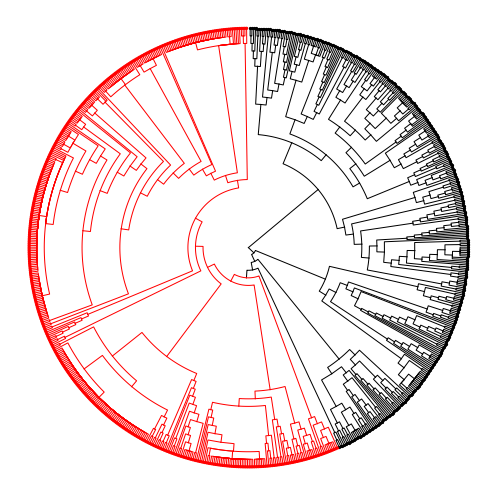

In [25]:
cas.pl.plot_matplotlib(tree, clade_colors={expanding_nodes[6]: "red"})

In highlighting where expansions occurred, we can partition the tree into groups of more- and less-aggressive subpopulations. We highlight in red one such population that is likely more aggressive as it is a detected expansion.

In the original study, the authors found that **distinct transcriptional patterns** are associated with **expanding regions** that likely confer a fitness advantage. 

#### Inferring tree plasticity

Tumors from this model consist of cells from various transcriptional states. The heterogeneity of this dataset can be observed on a low-dimensional projection of this dataset, such as those computed with UMAP: 

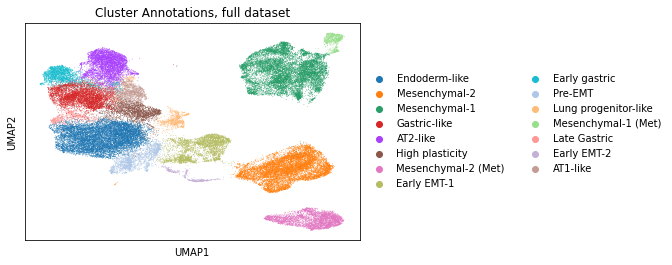

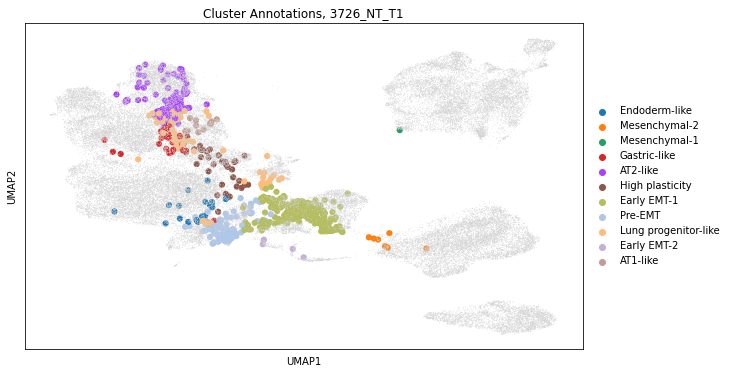

In [71]:
kptracer_adata = sc.read_h5ad("KPTracer-Data/expression/adata_processed.nt.h5ad")
sc.pl.umap(
    kptracer_adata,
    color="Cluster-Name",
    show=False,
    title="Cluster Annotations, full dataset",
)
plt.show()

# plot only tumor of interest
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()
sc.pl.umap(kptracer_adata[tree.leaves, :], color="Cluster-Name", show=False, ax=ax)
sc.pl.umap(
    kptracer_adata[np.setdiff1d(kptracer_adata.obs_names, tree.leaves), :],
    show=False,
    ax=ax,
    title=f"Cluster Annotations, {tumor}",
)
plt.show()

The visualization of single-cell transcriptome clusters on the UMAP reveals a **continuum of cellular states** that can populate a tumor. As the authors had expected, these states had been described in previous work which suggested that the CRISPR/Cas9-based recording did not noticeably perturb tumor development.

We can also just subset to the cells that are in our tumor of interest and observe that even in this **single tumor**, cells **occupy disparate transcriptional states.**

Separately, we can overlay the cellular state assignments onto the hierarchical structure of the tree and evaluate the heritability of cellular states. In visualizing, we can see that certain parts of the lineage are more mixed than others.

(<Figure size 504x504 with 1 Axes>, <AxesSubplot:>)

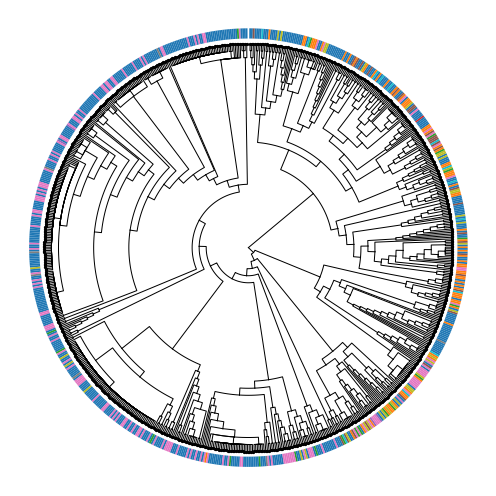

In [32]:
tree.cell_meta = pd.DataFrame(
    kptracer_adata.obs.loc[tree.leaves, "Cluster-Name"].astype(str)
)

cas.pl.plot_matplotlib(tree, meta_data=["Cluster-Name"])

In the visualization above, the color bar on the outside of the tree represents the cluster annotation of each cell. If states were very stable across generations, we'd expect to see strong coherence of state assignments between adjacent cells. However, above, we see that cells often are in a different state than their closest neighbor (especially on the right-hand side of the phylogeny).

The **instability** of these cellular states has been referred to as **"effective plasticity"** and several algorithms can be used to quantify it. One approach is to use the Fitch-Hartigan maximum-parsimony algorithm to infer the minimum number of times that cellular states had to have changed to give rise to the observed pattern. This function is implemented in Cassiopeia and can be utilized as below:

In [31]:
parsimony = cas.tl.score_small_parsimony(tree, meta_item="Cluster-Name")

plasticity = parsimony / len(tree.nodes)

print(f"Observed effective plasticity score of {plasticity}.")

Observed effective plasticity score of 0.2356902356902357.


This effective plasticity score is a score between 0 and 1 indicating how mixed the lineage is overall. A score of 0 would indicate no mixture at all and 1 would indicate that every cell has a different state than its sisters.

Often, we are more concerned with single-cell measurements of effective plasticity. We can compute a single-cell plasticity score as below:

In [33]:
# compute plasticities for each node in the tree
for node in tree.depth_first_traverse_nodes():
    effective_plasticity = cas.tl.score_small_parsimony(
        tree, meta_item="Cluster-Name", root=node
    )
    size_of_subtree = len(tree.leaves_in_subtree(node))
    tree.set_attribute(
        node, "effective_plasticity", effective_plasticity / size_of_subtree
    )

tree.cell_meta["scPlasticity"] = 0
for leaf in tree.leaves:
    plasticities = []
    parent = tree.parent(leaf)
    while True:
        plasticities.append(tree.get_attribute(parent, "effective_plasticity"))
        if parent == tree.root:
            break
        parent = tree.parent(parent)

    tree.cell_meta.loc[leaf, "scPlasticity"] = np.mean(plasticities)

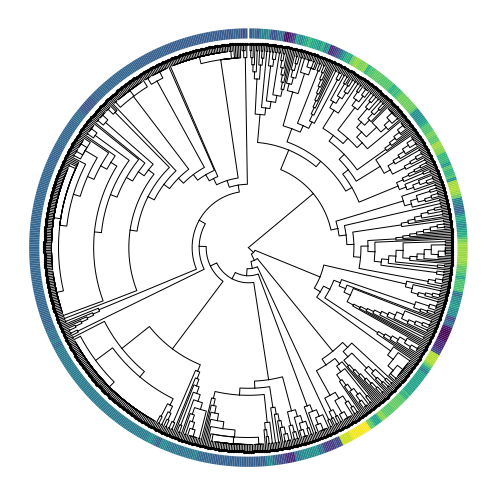

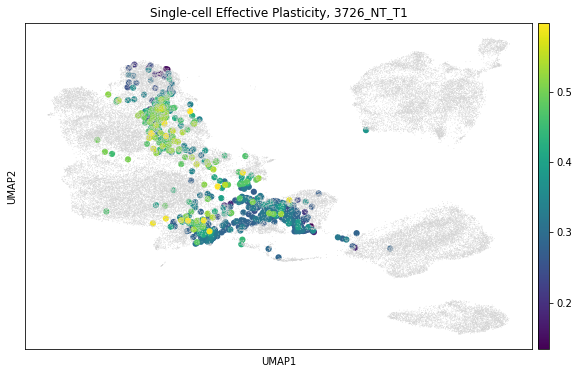

In [35]:
cas.pl.plot_matplotlib(tree, meta_data=["scPlasticity"])

kptracer_adata.obs["scPlasticity"] = np.nan
kptracer_adata.obs.loc[tree.leaves, "scPlasticity"] = tree.cell_meta["scPlasticity"]

# plot only tumor of interest
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()
sc.pl.umap(kptracer_adata[tree.leaves, :], color="scPlasticity", show=False, ax=ax)
sc.pl.umap(
    kptracer_adata[np.setdiff1d(kptracer_adata.obs_names, tree.leaves), :],
    show=False,
    ax=ax,
)
plt.title(f"Single-cell Effective Plasticity, {tumor}")
plt.show()

In comparing the patterns of **inferred effective plasticity** on the tree and the low-dimensional visualization, we can observe that as expected regions with more mixing between transcriptional states have higher effective plasticity. We can also observe that the effective plasticity appears to be enriched in "mid-stage" clusters like the "AT1-like" and "High-Plasticity" states.

**For additional discussion into these patterns, we refer the reader to the original study {cite}`yang2022`.**  

## Conclusions

In this chapter we have provided an overview of lineage tracing technologies and presented a case study for CRISPR/Cas9-based lineage tracing analysis using a recent dataset. Here, in closing, we point to additional **resources** for lineage tracing analysis and tool development as well as highlight the **key takeaways** for new users.

As this is an emerging field we expect to see a rise in the number of large-scale time-series lineage traced datasets which and that novel computational tools tailored for the analysis of this data will be developed, {cite}`rodriguez2022` and {cite}`mukhopadhyay2022`. We anticipate that the main focus will be put into methods which integrate gene-expression with lineage information hence providing a more complete biological picture of individuals. Further, following the new-directions detailed below we expect that methods will focus on trajectory inference from time series data. 


## New directions

### New phylogenetic inference algorithms

In terms of new lineage inference algorithms, there are many promising directions: 

- **Scalable bayesian inference**: Mirroring the trends of more traditional phylogenetic algorithms, one potential direction is that of scaling Bayesian approaches to larger inputs. While most Bayesian algorithms have leveraged Markov chain Monte Carlo (MCMC) to estimate the posterior distribution {cite}`huelsenbeck2001`, advances in variational inference would greatly improve the scalability of Bayesian algorithms {cite}`zhang2018`. The probablistic nature of such an advance would support high-throughput uncertainty estimation of the tree as well as fit naturally with other single-cell transcriptomic Bayesian approaches, like scVI {cite}`lt:Lopez2018`.
- **Improved distance-based algorithms**: A fundamental aspect of distance-based algorithms is the estimation of dissimilarities between samples based on their mutation data and known properties of the dataset. With this in mind, a promising direction is that of developing more statistically robust and consistent dissimilarity functions for evolving lineage tracers by taking into account properites of how mutations arise and the priors on the likelihoods of specific mutations. Already, this has proven successful with DCLEAR {cite}`gong2021` and {cite}`fang2022`. Continuing advances in this realm would be greatly enabling as distance-based algorithms can run in polynomial time and produce very accurate trees with an adequate dissimilarity function.

### Computational tools to interpret time-course lineage tracing data

The increasing complexity of lineage tracing studies which include time-course information must be accompanied by computational methods which extend the analysis beyond the construction of phylogenetic trees. That is, methods that integrate multi-omics measurements with lineage tracing and temporal information to enable recovery of programs governing cell state, differentiation and behavior {cite}`mukhopadhyay2022`. 

As this field is at its beginning the number of available tools is still limited, yet it is worth highlighting leading approaches: 
- **`LineageOT` for evolving CRISPR/Cas9-based setting** {cite}`forrow2021`: A general-purpose method for inferring developmental trajectories from scRNA-seq time courses equipped with lineage information each time point applicable for evolving CRISPR/Cas9-based setting. The method was suggested as an extension of the Waddington OT {cite}`schiebinger2019` algorithm to take the lineage relationships into account when mapping cells from earlier to later time-points. When computing transition matrices across pairs of time-points, LineageOT corrects expression profiles in the later time-point based on their lineage similarity. This method has been successfully applied for the reconstruction of time-course of *C. elegans* development. Further, through simulation it was proven that `LineageOT` can accurately recover complex trajectory structures that are impossible to recover from measurements of cell state alone. For more details and tutorials we refer the reader to https://lineageot.readthedocs.io.
- **`CoSpar` for static barcoding lineage tracing data** {cite}`wang2022`: A computational approach to infer cell dynamics from single-cell transcriptomics integrated with static barcoding lineage tracing data. The method relies on two basic assumptions on the nature of biological dynamics: (i) cells in similar states behave similarly and (ii) cells limit their possible dynamics to give sparse transitions. The application of `CoSpar` is demonstrated on hematopoiesis, reprogramming and directed differentiation datasets. These examples show that `CoSpar` can identify early fate biases not previously detected, predicting transcription factors and receptors implicated in fate choice. Documentation and detailed examples can be found at https://cospar.readthedocs.io/.

### Resources for developing new computational methods

While the current repertoire of analytical tools are quite powerful, there is a great opportunity for further development. To facilitate future efforts, we highlight a few tools for benchmarking algorithms:

- The recent Allen Institute Lineage Reconstruction DREAM challenge {cite}`gong2021` generated three benchmarking datasets that were used to evaluate new algorithms. Two of these datasets were synthetic (i.e., simulated) whereas one was generated with the intMEMOIR {cite}`chow2021` technology. The recently published results offer insights into the behavior of successful algorithms as well as provides access to these benchmarking datasets {cite}`gong2021`.
- `Cassiopeia-benchmark` is a module within Cassiopeia that allows users to efficiently generate simulated lineage data for benchmarking new lineage reconstruction algorithms. While there is a strong focus on CRISPR/Cas9-based evolving tracer simulations, the general simulator API can be extended for additional technological considerations. The authors have provided a detailed walkthrough of using this benchmarking suite on [their website](https://cassiopeia-lineage.readthedocs.io/en/latest/notebooks/benchmark.html). 
- `TedSim` is a simulation framework for not only simulating barcoding data but also transcriptomic data on top of a lineage {cite}`pan2022`. This simulation framework can be very useful for testing downstream analytical tools, such as those designed to infer developmental trajectories from lineage tracing data.

## Key takeaways

- Remember, the **resolution of experimental data** is still limited. **Statistical analysis** and **assessment of the quality** of lineage information shall be performed in order to identify individuals for which lineage reconstruction can be applied. As demonstrated above there are dedicated tools which easily provide the relevant statistics.
- Often it is difficult to presume **which algorithm** will perform best for reconstruction, and even algorithms with good performances might highlight different part of lineages. It is recommended that you **apply a few algorithms** for reconstruction for comparisons.
- As with any analysis without a certain ground truth, any **conclusions must be carefully drawn**. First and foremost, it is always good practice to visualize lineages along with the indel heatmap to verify that no obvious reconstruction errors were made (see the section entitled "Reconstructing the lineage" for more tips on how to evaluate reconstruction accuracy by eye). Additionally, an effective strategy for drawing stronger conclusions is to compare downstream analyses on the same lineage inferred with different algorithms. Of course, as with most matters concerning computational conclusions, we often suggest that conclusions are validated in an experimental system.


## References

```{bibliography}
:filter: docname in docnames
```

## Contributors

We gratefully acknowledge the contributions of:

### Authors

* Matthew Gregory Jones
* Zoe Piran

### Reviewers

* Aaron McKenna
* Lukas Heumos